In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
df_clv = pd.read_csv("./dataset/data_customer_lifetime_value.csv")

#### **2. DATA UNDERSTANDING**

In [4]:
df_clv.head(3)

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810


In [5]:
df_clv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Vehicle Class            5669 non-null   object 
 1   Coverage                 5669 non-null   object 
 2   Renew Offer Type         5669 non-null   object 
 3   EmploymentStatus         5669 non-null   object 
 4   Marital Status           5669 non-null   object 
 5   Education                5669 non-null   object 
 6   Number of Policies       5669 non-null   float64
 7   Monthly Premium Auto     5669 non-null   float64
 8   Total Claim Amount       5669 non-null   float64
 9   Income                   5669 non-null   float64
 10  Customer Lifetime Value  5669 non-null   float64
dtypes: float64(5), object(6)
memory usage: 487.3+ KB


Dari hasil informasi singkat dataset terdiri dari 11 Column dengan jumlah total row 5669 (termasuk dalam proporsi dataset yang kecil). Ada 5 variable numerical dan 6 variable kategorikal, Tidak ada informasi missing value namun pengecekan terhadap duplikasi data akan dilakukan diproses selanjutnya.

##### **2.1 Descriptive Analysis**

##### 2.1.1 Numerical Features Analysis

In [6]:
df_clv.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of Policies,5669.0,2.979361,2.393187,1.000000,1.000000,2.000000,4.000000,9.000000
Monthly Premium Auto,5669.0,93.026989,34.551795,61.000000,68.000000,82.000000,109.000000,297.000000
Total Claim Amount,5669.0,431.407103,287.558038,0.423310,266.932542,379.200000,549.986128,2759.794354
Income,5669.0,37868.188569,30490.490723,0.000000,0.000000,34322.000000,62464.000000,99934.000000
Customer Lifetime Value,5669.0,8029.874592,6916.708246,1898.007675,3954.344534,5800.188903,9031.214859,83325.381190


- `Number of Policies` : kebanyakan pelanggan memiliki polis antara 1 sampai 4 dengan sedikit yang memiliki lebih banyak dari 4 (hingga 9), namun hal ini juga dapat menjadi pertanda adanya outliers pada feature ini.

- `Monthly Premium Auto` : Sebagian pelanggan membayar premi bulanannya antara nilai 68 - 109, beberapa pelanggan ada yang membayar jauh lebih tinggi dari 109 hingga 297. hal ini juga dapat menjadi identifikasi adanya jumlah outliers yang besar pada feature ini.

- `Total Claim Amount` : Mayoritas pelanggan mengajukan klaim total dalam rentang 267 hingga 550, tetapi ada klaim yang sangat tinggi hingga sekitar 2759.79. Ini mungkin menunjukkan adanya beberapa klaim besar yang mempengaruhi rata-rata, menunjukkan *right-skew distribution*

- `Income` : Distribusi pendapatan pelanggan sangat bervariasi, dengan beberapa pelanggan memiliki pendapatan yang sangat rendah (atau tidak tercatat) dan beberapa lainnya memiliki pendapatan yang sangat tinggi. Adanya nilai nol di kuartil pertama menunjukkan beberapa pelanggan mungkin tidak memiliki pendapatan yang tercatat atau tidak menghasilkan pendapatan.

- `Customer Lifetime Value` :Nilai pelanggan seumur hidup memiliki distribusi yang luas dengan sebagian besar pelanggan berada dalam rentang 3,954 hingga 9,031. Namun, ada pelanggan dengan nilai seumur hidup yang sangat tinggi hingga 83,325.38, menunjukkan beberapa pelanggan memiliki kontribusi yang sangat besar terhadap perusahaan atau bisa menjadi indikasi outliers yang besar.

##### 2.1.2 Categorical Features Analysis

In [7]:
df_clv.describe(include='object').T

,count,unique,top,freq
Vehicle Class,5669,6,Four-Door Car,2858
Coverage,5669,3,Basic,3477
Renew Offer Type,5669,4,Offer1,2292
EmploymentStatus,5669,5,Employed,3541
Marital Status,5669,3,Married,3305
Education,5669,5,Bachelor,1703


#### **2.2 Data Distribution**


Pengecekan distribusi data sangat penting karena pemilihan model machine learning yang tepat harus mempertimbangkan bagaimana model tersebut berinteraksi dengan distribusi data. Beberapa model machine learning memiliki asumsi tertentu mengenai distribusi data, seperti distribusi normal. Misalnya, model regresi linier klasik mengasumsikan bahwa residualnya terdistribusi normal. Jika data tidak memenuhi asumsi ini, hasil model dapat menjadi tidak valid. Sebaliknya, model non-parametrik seperti Decision Tree atau algoritma ensemble ( Random Forest & Gradient Boosting) tidak memerlukan asumsi distribusi tertentu dan dapat menangani berbagai distribusi data, baik yang normal maupun tidak normal.


Pada Tahap ini saya akan melakukan metode pengujian dengan 2 pendekatan berbeda, pertama dengan mengunakan uji statistik yaitu uji normalitas menggunakan KS-Test dan Shapiro-Wilk Test. Kemudian kedua dilakukan dengan uji visualisasi menggunakan histogram, Plot Q-Q dan Box-plot. perbedaan diantara metode tersebut juga akan saya jelaskan nantinya.

##### 2.2.1 Normality Test

In [34]:
numerical_columns = df_clv.select_dtypes(include='number').columns

results = {}

# 1. Perform normality test using two selected method : KS-Test and Shapiro-wilk test

for column in numerical_columns:
    
    data = df_clv[column]
    
    ks_statistic, ks_p_value = stats.kstest(data, 'norm')
    
    shapiro_statistic, shapiro_p_value = stats.shapiro(data)
    
    results[column] = {
        'ks_statistic' : ks_statistic,
        'ks_p_value' : ks_p_value,
        'shapiro_statistic' : shapiro_statistic,
        'shapiro_p_value' : shapiro_p_value,   
    }
    
    
# 2. Display the normality test result
for col, result in results.items():
    print(f'\nNormality Test For Column: {col}')
    
    print(f'KS P-value: {result["ks_p_value"]}')
    
    if result['ks_p_value'] < 0.05:
        print('Hipotesis 0 ditolak, Data tidak terdistribusi normal')
    else:
        print('Tidak Menolak Hipotesis 0, Data terdistribusi normal')
    
    print(f'Shapiro-Wilk P-value: {result["shapiro_p_value"]}')
    
    if result['shapiro_p_value'] < 0.05:
        print('Hipotesis 0 ditolak, Data tidak terdistribusi normal')
    else:
        print('Tidak Menolak Hipotesis 0, Data terdistribusi normal')



Normality Test For Column: Number of Policies
KS P-value: 0.0
Hipotesis 0 ditolak, Data tidak terdistribusi normal
Shapiro-Wilk P-value: 9.329811886752308e-66
Hipotesis 0 ditolak, Data tidak terdistribusi normal

Normality Test For Column: Monthly Premium Auto
KS P-value: 0.0
Hipotesis 0 ditolak, Data tidak terdistribusi normal
Shapiro-Wilk P-value: 2.098028447148289e-65
Hipotesis 0 ditolak, Data tidak terdistribusi normal

Normality Test For Column: Total Claim Amount
KS P-value: 0.0
Hipotesis 0 ditolak, Data tidak terdistribusi normal
Shapiro-Wilk P-value: 1.2014246420232636e-52
Hipotesis 0 ditolak, Data tidak terdistribusi normal

Normality Test For Column: Income
KS P-value: 0.0
Hipotesis 0 ditolak, Data tidak terdistribusi normal
Shapiro-Wilk P-value: 2.464125605071974e-47
Hipotesis 0 ditolak, Data tidak terdistribusi normal

Normality Test For Column: Customer Lifetime Value
KS P-value: 0.0
Hipotesis 0 ditolak, Data tidak terdistribusi normal
Shapiro-Wilk P-value: 5.427409664584

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5669.
  res = hypotest_fun_out(*samples, **kwds)


Dari hasil uji normalitas, semua p_value yang diperoleh menggunakan 2 metode pengujian berada dibawah 0.05 semuanya, sehingga hipotesis nol ditolak (dalam hal ini yang dimaksud hipotesis nol artinya mengasumsikan bahwasannya data dalam keadaan terdistribusi secara normal) maka semuanya termasuk dalam data yang tidak terdistribusi normal.

##### 2.2.2 Visualization Test

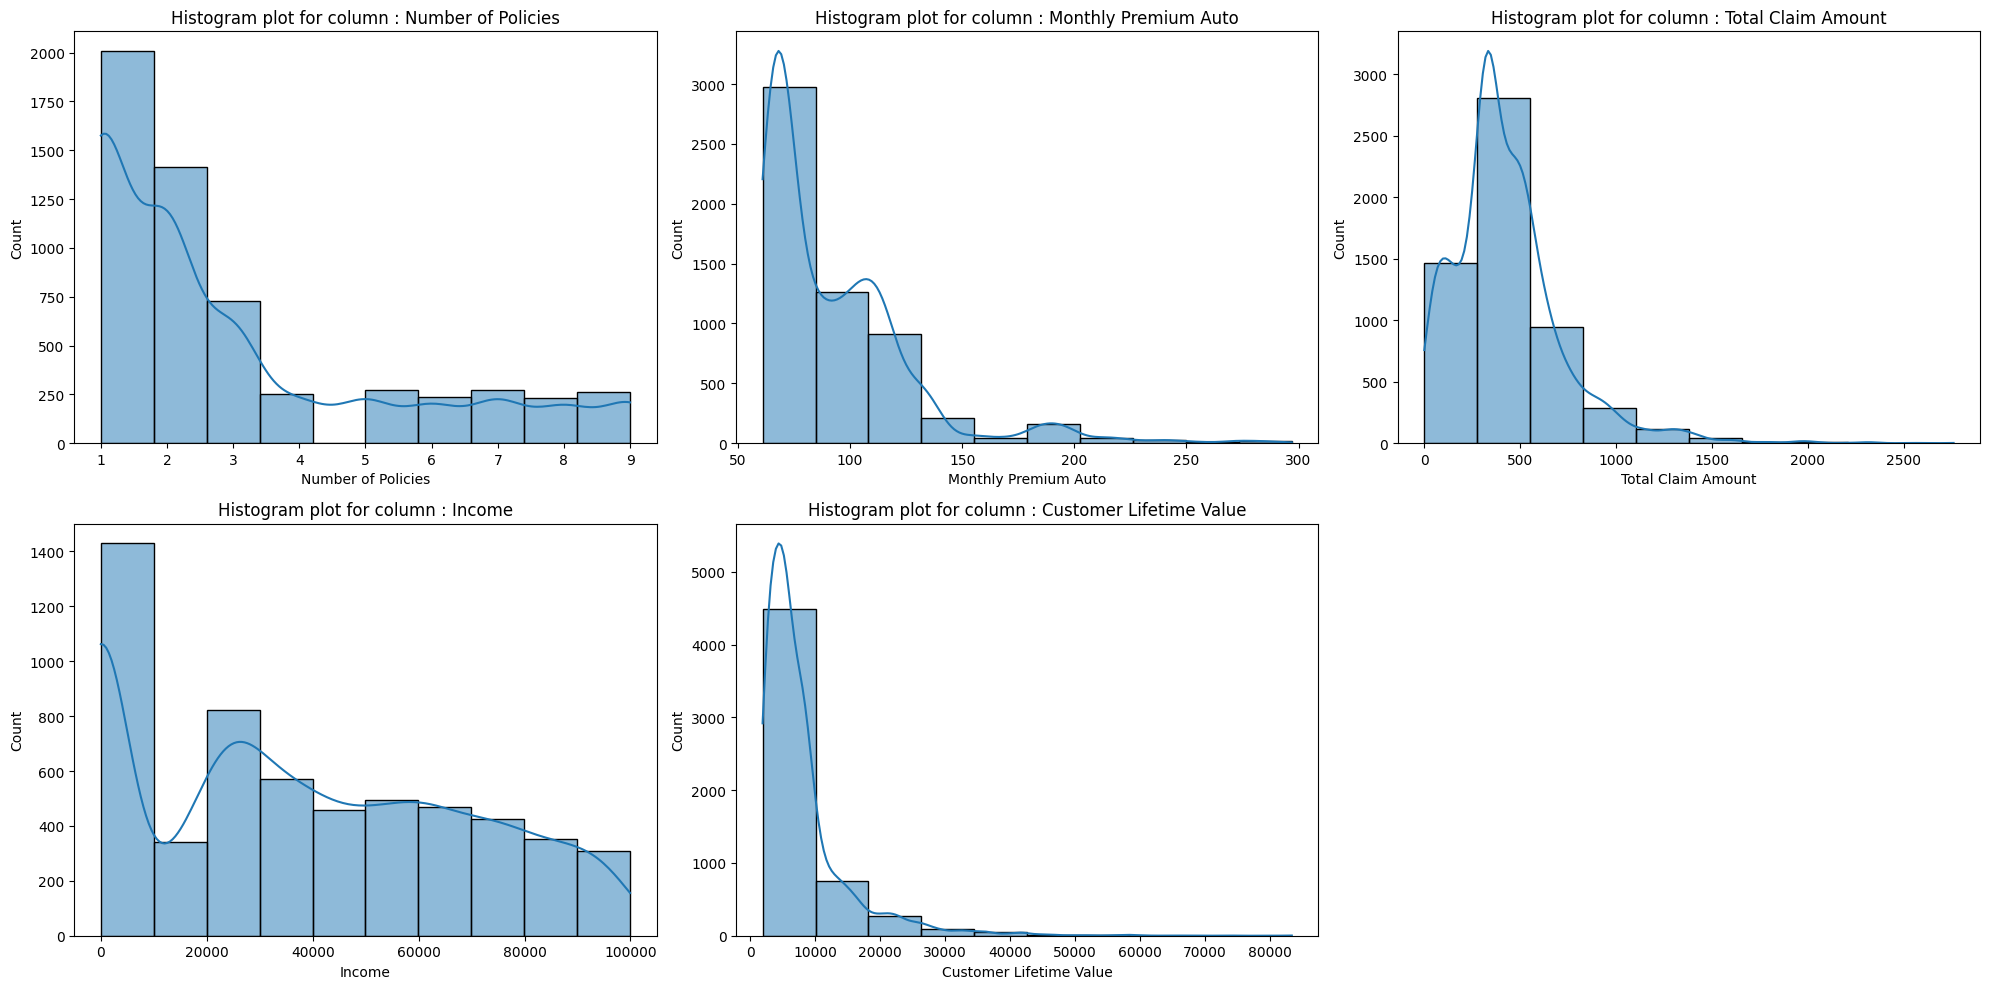

In [35]:
# 1. Visualization using Histogram Plot

fig = plt.figure(figsize=(20,10))
subplot = 1

for column in numerical_columns : 
    plt.subplot(2,3,subplot)
    sns.histplot(df_clv[column].dropna(), kde=True, bins=10)
    plt.title(f'Histogram plot for column : {column}')
    plt.tight_layout()
    subplot += 1

Dari hasil uji visualisasi menggunakan histogram, kelima fitur terdistribusi secara tidak normal, yang terlihat dari ekor panjang yang mengarah ke kanan. Hal ini menandakan bahwa distribusi data adalah right-skewed (skewness ke kanan).

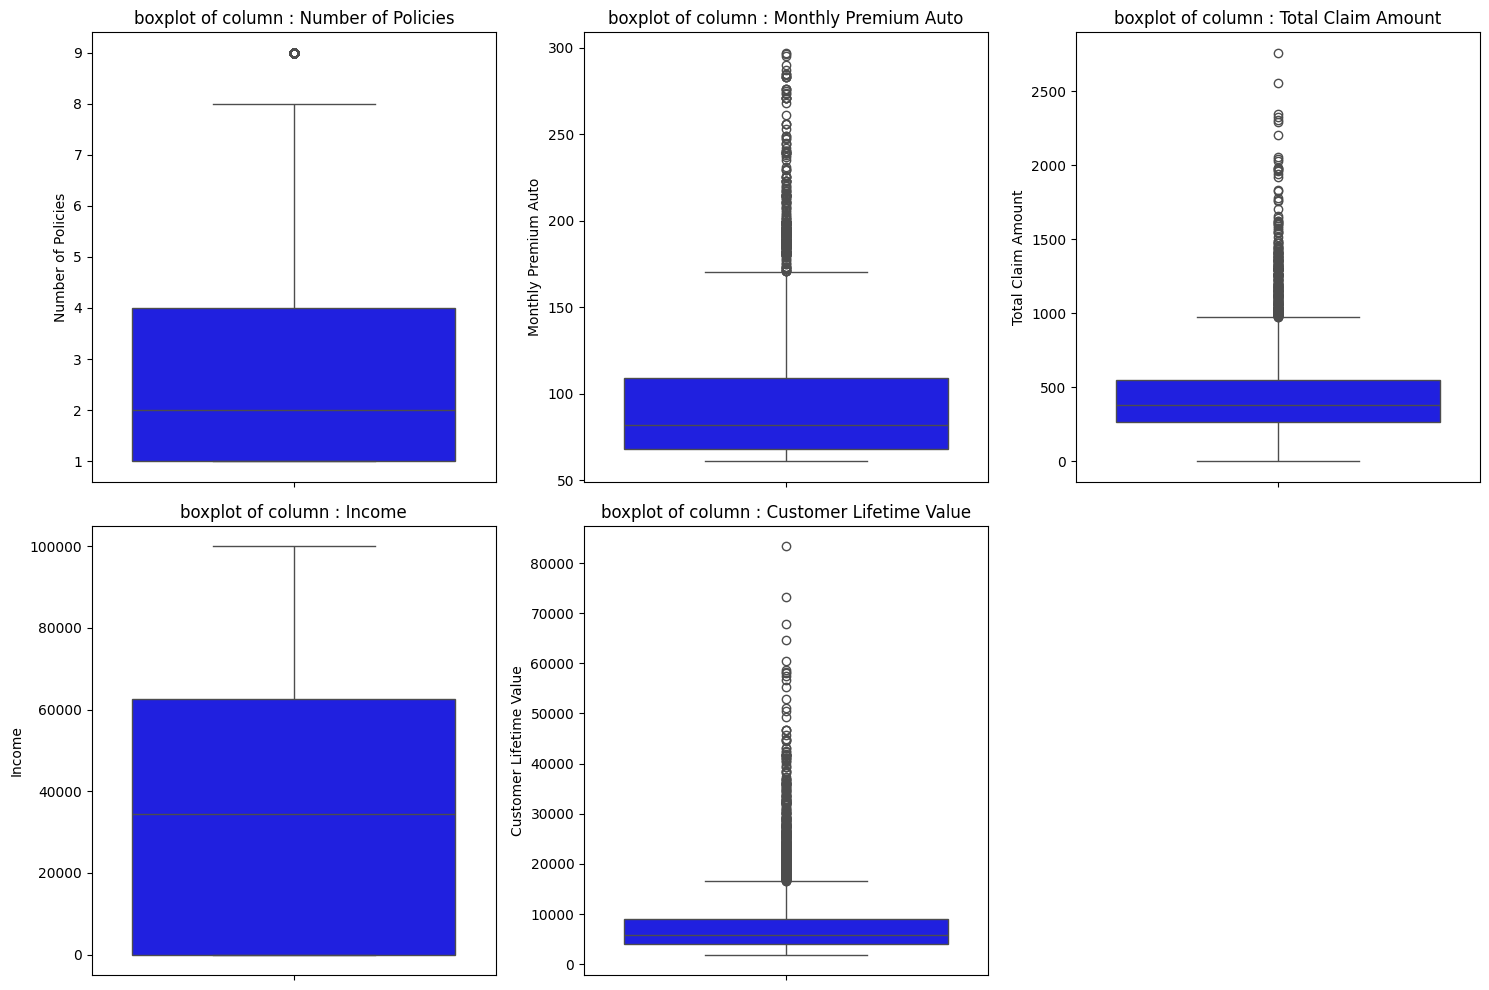

In [38]:
# Visualization using boxplot 
plt.figure(figsize=(15,10))

for i in range(0, len(numerical_columns)) :
    plt.subplot(2, 3, i+1)
    sns.boxplot(y = df_clv[numerical_columns[i]], color='blue', orient='v')
    plt.title(f'boxplot of column : {numerical_columns[i]}')
    plt.tight_layout()

Hasil yang sama juga ditunjukkan oleh boxplot, di mana distribusi data yang tidak normal terlihat dari ekor panjang yang memanjang ke arah kanan. Hasil visualisasi juga menunjukkan bahwa feature memiliki jumlah outliers yang cukup besar untuk column `Customer Lifetime Value`, `Monthly Premium auto` dan `total_claim_amount`

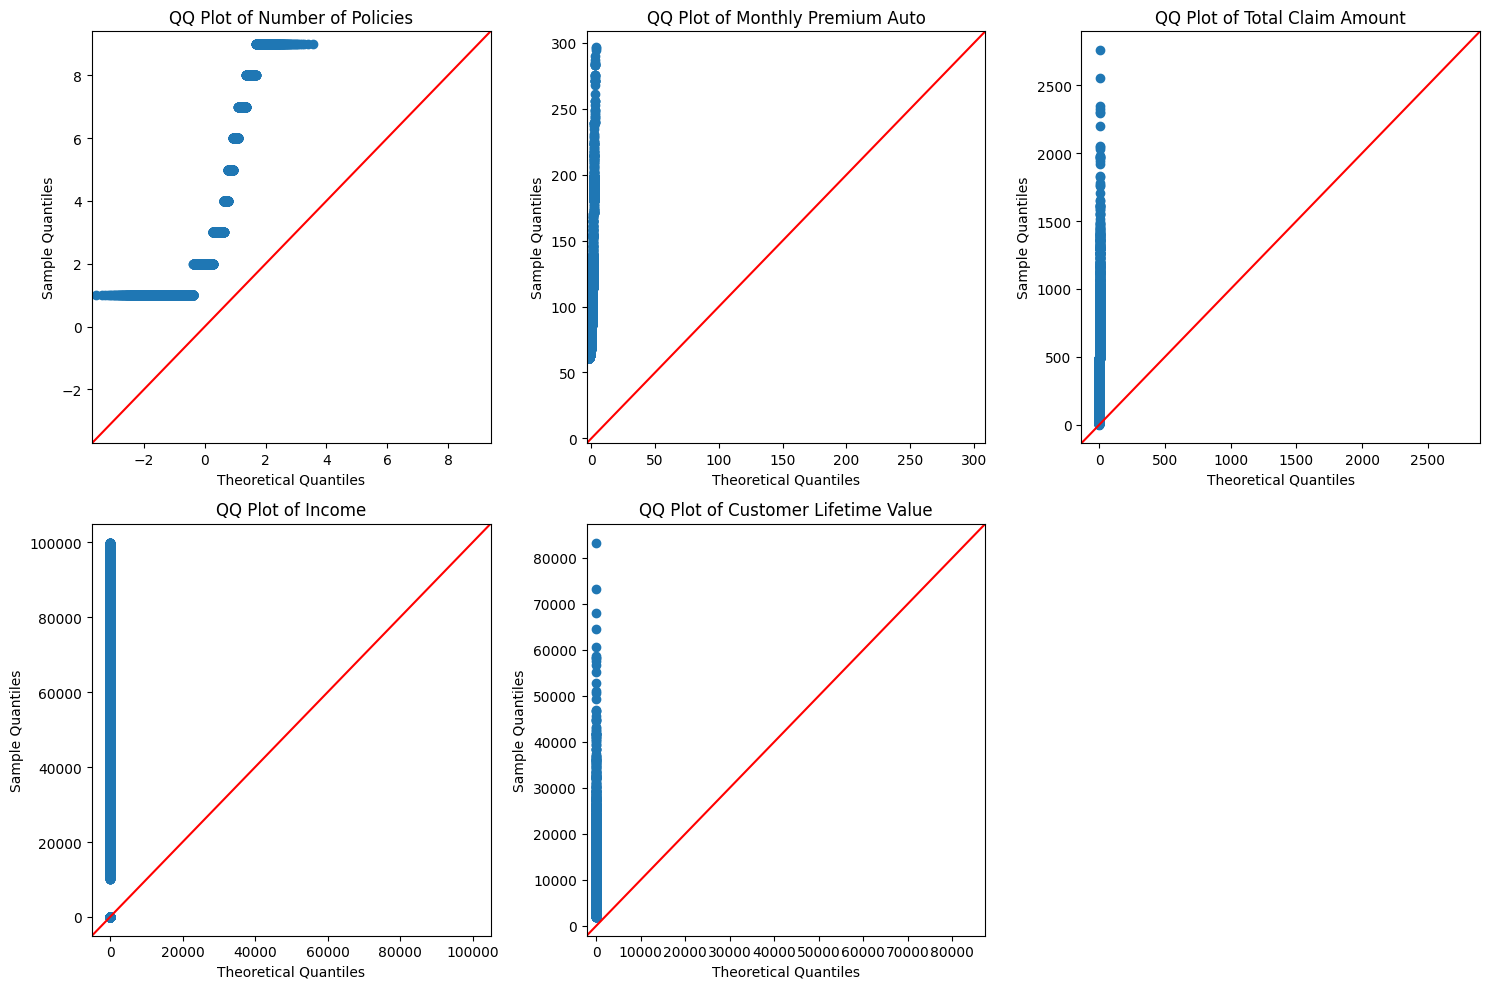

In [47]:
import statsmodels.api as sm

numerical_columns = df_clv.select_dtypes(include='number').columns

# Visualization using QQ plot
plt.figure(figsize=(15, 10))

for i in range(len(numerical_columns)):
    plt.subplot(2, 3, i+1)  # 2 baris, 3 kolom
    sm.qqplot(df_clv[numerical_columns[i]], line ='45', ax=plt.gca())
    plt.title(f'QQ Plot of {numerical_columns[i]}')
    plt.tight_layout()

plt.show()


Dari visualisasi QQ plot, terlihat jelas bahwa kumpulan titik (berwarna biru) tidak mengikuti garis referensi merah pada sudut 45 derajat. Hal ini menunjukkan bahwa data tidak terdistribusi secara normal

##### **2.3. Duplicate Data, Missing and Negative Value**

In [49]:
df_clv.duplicated().sum()

618

ada 618 data yang terduplikasi, nantinya akan dibuang pada proses data pre-processing. namun akan tetap dipakai pada proses EDA. Alasannya karna terkadang dapat memberikan wawasan berharga, seperti mengidentifikasi pola yang berulang atau memahami perilaku pelanggan.

In [51]:
def check_df(df):
    df = pd.DataFrame({
        'feature':df.columns.values,
        'data_type':df.dtypes.values,
        'null':df.isna().mean().values * 100,
        'negative':[True if df[i].dtype == int and (df[i] < 0).any() else False for i in df.columns],
        'n_unique':df.nunique().values,
       'duplicate': [df[col].duplicated().any() for col in df.columns],
        'sample_unique':[df[i].unique()[:3] for i in df.columns]
    })
    return df

check_df(df_clv)

,feature,data_type,null,negative,n_unique,duplicate,sample_unique
0,Vehicle Class,object,0.0,False,6,True,"[Four-Door Car, Two-Door Car, SUV]"
1,Coverage,object,0.0,False,3,True,"[Extended, Basic, Premium]"
2,Renew Offer Type,object,0.0,False,4,True,"[Offer1, Offer3, Offer2]"
3,EmploymentStatus,object,0.0,False,5,True,"[Retired, Employed, Disabled]"
4,Marital Status,object,0.0,False,3,True,"[Divorced, Married, Single]"
5,Education,object,0.0,False,5,True,"[High School or Below, College, Master]"
6,Number of Policies,float64,0.0,False,9,True,"[2.0, 6.0, 1.0]"
7,Monthly Premium Auto,float64,0.0,False,191,True,"[90.0, 62.0, 116.0]"
8,Total Claim Amount,float64,0.0,False,3274,True,"[571.479602, 114.51444, 257.248789]"
9,Income,float64,0.0,False,3625,True,"[11828.0, 44762.0, 21514.0]"


Hasil pengecekan menunjukkan tidak ada data yang bernilai negative maupun missing value

#### **3. Exploratory Data Analysis (EDA)**

In [58]:
df_clv.head(2).T

,0,1
Vehicle Class,Four-Door Car,Four-Door Car
Coverage,Extended,Basic
Renew Offer Type,Offer1,Offer1
EmploymentStatus,Retired,Employed
Marital Status,Divorced,Married
Education,High School or Below,College
Number of Policies,2.0,6.0
Monthly Premium Auto,90.0,62.0
Total Claim Amount,571.479602,114.51444
Income,11828.0,44762.0


In [76]:
df_clv.groupby('Vehicle Class')['Customer Lifetime Value'].describe(include='object').T

Vehicle Class,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car
count,2858.000000,107.000000,115.000000,1096.000000,307.000000,1186.000000
mean,6641.095206,16779.425415,17730.511533,10369.130854,11121.754994,6684.448077
std,5210.052492,12131.603682,13252.089648,7712.770987,8883.607717,5284.877947
min,1904.000852,5886.221122,6383.611136,3099.538005,3074.105486,1898.007675
25%,3165.342689,8710.330257,8427.172486,4881.493478,5285.399325,2983.884805
50%,5319.488900,14510.750500,14854.195520,8628.816326,8608.157233,5211.711468
75%,7628.477287,18969.954670,19160.989940,12168.744920,11857.538625,7575.802526
max,41787.903430,83325.381190,73225.956520,58753.880460,67907.270500,35444.314040


<Axes: xlabel='Customer Lifetime Value', ylabel='Total Claim Amount'>

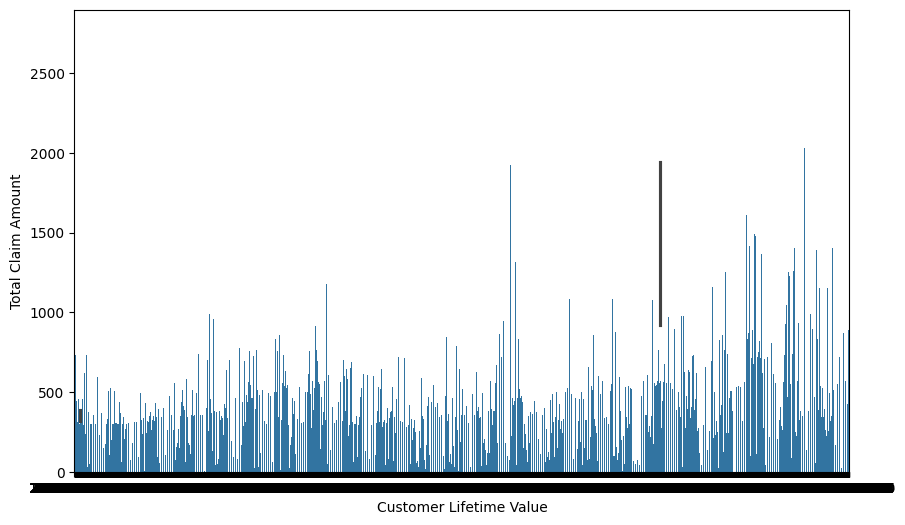

In [64]:
plt.figure(figsize=(10,6))
sns.barplot(data=)